# Statistical Inference Analysis: Key Drivers of Restaurant Customer Footfall

**Author:** Akshat Kalra  
**Date:** April 2025  
**Analysis Type:** Inferential Statistics | Quasi-Poisson Regression

---

In [1]:
# Installing necessary packages
install.packages("ggcorrplot")

# Importing necessary libraries
library('tidyverse')
library(broom)
library(ggcorrplot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Introduction

Understanding what drives customer footfall is vital for restaurant success. Factors such as pricing, cuisine type, marketing, and promotions can all influence customer behavior, but identifying which of these variables have the **strongest association** with customer volume can be challenging. This analysis uses a synthetic dataset designed to simulate real-world restaurant business features.

We aim to investigate the key explanatory variables that are most strongly associated with the number of customers visiting a restaurant per month. Specifically, we ask:

> **Which explanatory variable has the strongest association on the number of customers visiting a restaurant per month (response variable - `Number_of_Customers`), based on the significance and magnitude of coefficients in a Poisson regression model, assuming the number of customers follows a Poisson distribution?**

This question falls under the domain of **inference**, as we are not just aiming to predict the number of customers, but to understand the relationship between potential predictors and the response variable using statistical modeling.

We assume that the response variable follows a **Poisson distribution**, which is appropriate for count data. Our analysis will rely on a Poisson regression model, with attention to both the **statistical significance** and the **magnitude** of estimated coefficients to evaluate the strength of associations.

While the dataset is synthetic and was generated for educational purposes, the analytical approach and modeling techniques mirror those used in real-world statistical inference tasks in business and marketing analytics.


# Methods and Results: Data

## (1) Data Description

### About Dataset
The Restaurant Revenue Prediction Dataset is a comprehensive collection of simulated data designed for predicting monthly revenue for a set of fictitious restaurants. This dataset was created for educational and illustrative purposes, allowing data enthusiasts to explore and experiment with machine learning algorithms for regression tasks.

### Citation
MrSimple07. (2024). Restaurants Revenue Prediction [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/7420974

### How was the data collected?
The Restaurant Revenue Prediction Dataset is a synthetic dataset created for educational and illustrative purposes. It does not originate from real-world data sources, and any resemblance to actual entities or establishments is purely coincidental. The dataset was generated using random data generation techniques to simulate various aspects of restaurant operations.


In [2]:
# Loading the data directly from Kaggle using its API

# Note for the TA/Prof: You will have to enter your Kaggle username and API key to reproduce this notebook
kaggle_api <- '{"username":"Enter Username","key":"Enter API key"}'

dir.create("~/.kaggle", showWarnings = FALSE)
writeLines(kaggle_api, "~/.kaggle/kaggle.json")
Sys.chmod("~/.kaggle/kaggle.json", mode = "600")

if (!file.exists("dataset/Restaurant_revenue.csv")) {
  system("kaggle datasets download -d mrsimple07/restaurants-revenue-prediction")
  system("unzip -o restaurants-revenue-prediction.zip -d dataset")
}

In [3]:
library(readr)
library(dplyr)

 # Loading the dataset
data <- read_csv("dataset/Restaurant_revenue.csv")

head(data)

Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Cuisine_Type
dbl (7): Number_of_Customers, Menu_Price, Marketing_Spend, Average_Customer_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
61,43.11764,12.663793,Japanese,36.23613,0,45,350.9120
24,40.02008,4.577892,Italian,17.95256,0,36,221.3191
81,41.98149,4.652911,Japanese,22.60042,1,91,326.5298
70,43.00531,4.416053,Italian,18.98410,1,59,348.1906
30,17.45620,3.475052,Italian,12.76614,1,30,185.0091
92,19.42767,13.114473,American,43.09995,1,10,399.8675


# Methods and Results: Exploratory Data Analysis (EDA)

In [4]:
# dimensions of the dataset
dataset_dims <- dim(data)
cat("The dataset has", dataset_dims[1], "observations and", dataset_dims[2], "variables.\n\n")

The dataset has 1000 observations and 8 variables.



In [5]:
# a table containing the variables in the dataset with its types and the description of each variable
var_summary <- data.frame(
    Variable_Name = names(data),
    Type = sapply(data, class),
    Description = c("The count of customers visiting the restaurant.",
                    "Average menu prices at the restaurant.",
                    "Expenditure on marketing activities.",
                    "The type of cuisine offered (Italian, Mexican, Japanese, American).",
                    "Average spending per customer.",
                    "Binary indicator (0 or 1) denoting whether promotions were conducted.",
                    "Number of reviews received by the restaurant.",
                    "Simulated monthly revenue, the target variable for prediction."),
    stringsAsFactors = FALSE
)
var_summary

,Variable_Name,Type,Description
,<chr>,<chr>,<chr>
Number_of_Customers,Number_of_Customers,numeric,The count of customers visiting the restaurant.
Menu_Price,Menu_Price,numeric,Average menu prices at the restaurant.
Marketing_Spend,Marketing_Spend,numeric,Expenditure on marketing activities.
Cuisine_Type,Cuisine_Type,character,"The type of cuisine offered (Italian, Mexican, Japanese, American)."
Average_Customer_Spending,Average_Customer_Spending,numeric,Average spending per customer.
Promotions,Promotions,numeric,Binary indicator (0 or 1) denoting whether promotions were conducted.
Reviews,Reviews,numeric,Number of reviews received by the restaurant.
Monthly_Revenue,Monthly_Revenue,numeric,"Simulated monthly revenue, the target variable for prediction."


In [6]:
# cleaning the data
data_clean <- data %>%
  filter(!is.na(Number_of_Customers),
         !is.na(Cuisine_Type),
         !is.na(Promotions)) %>%
  mutate(
    Cuisine_Type = as.factor(Cuisine_Type),
    Promotions = as.factor(Promotions)
    )
head(data_clean)

Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
61,43.11764,12.663793,Japanese,36.23613,0,45,350.9120
24,40.02008,4.577892,Italian,17.95256,0,36,221.3191
81,41.98149,4.652911,Japanese,22.60042,1,91,326.5298
70,43.00531,4.416053,Italian,18.98410,1,59,348.1906
30,17.45620,3.475052,Italian,12.76614,1,30,185.0091
92,19.42767,13.114473,American,43.09995,1,10,399.8675


In [7]:
# Summary statistics for the cleaned data
summary(data_clean)

# Checking for missing values after cleaning
sapply(data_clean, function(x) sum(is.na(x)))

 Number_of_Customers   Menu_Price    Marketing_Spend       Cuisine_Type
 Min.   :10.00       Min.   :10.01   Min.   : 0.003768   American:256  
 1st Qu.:30.00       1st Qu.:20.40   1st Qu.: 4.690724   Italian :232  
 Median :54.00       Median :30.86   Median :10.092047   Japanese:262  
 Mean   :53.27       Mean   :30.22   Mean   : 9.958726   Mexican :250  
 3rd Qu.:74.00       3rd Qu.:39.84   3rd Qu.:14.992436                 
 Max.   :99.00       Max.   :49.97   Max.   :19.994276                 
 Average_Customer_Spending Promotions    Reviews      Monthly_Revenue 
 Min.   :10.04             0:503      Min.   : 0.00   Min.   :-28.98  
 1st Qu.:19.60             1:497      1st Qu.:24.00   1st Qu.:197.10  
 Median :29.25                        Median :50.00   Median :270.21  
 Mean   :29.48                        Mean   :49.84   Mean   :268.72  
 3rd Qu.:39.55                        3rd Qu.:76.00   3rd Qu.:343.40  
 Max.   :49.90                        Max.   :99.00   Max.   :563.38  

Number_of_Customers                Menu_Price           Marketing_Spend 
                        0                         0                         0 
             Cuisine_Type Average_Customer_Spending                Promotions 
                        0                         0                         0 
                  Reviews           Monthly_Revenue 
                        0                         0

# EDA: Visualization 1

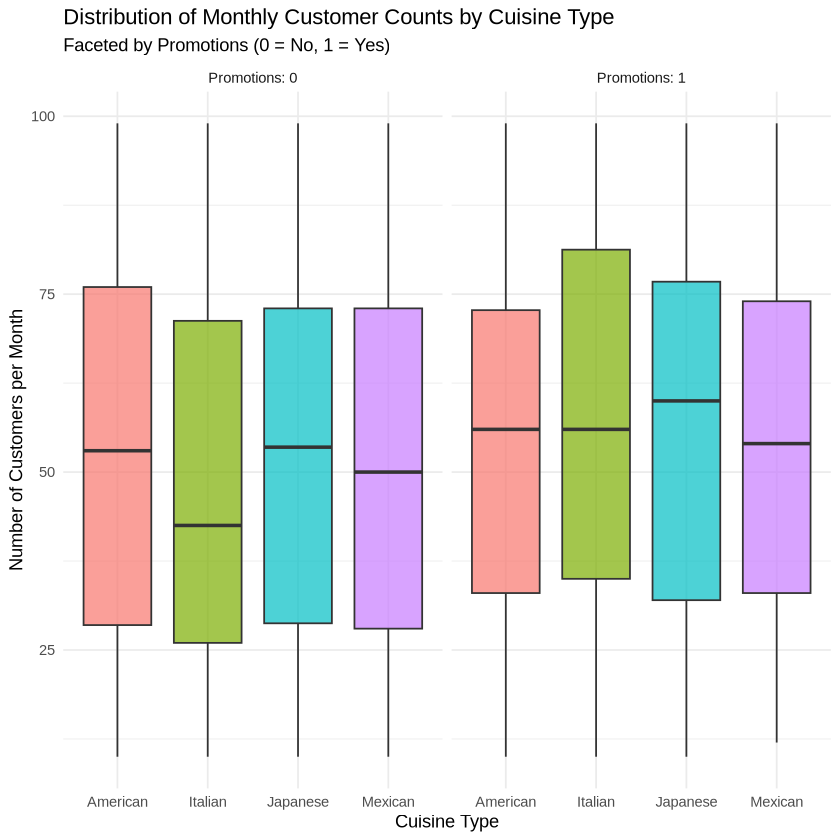

In [8]:
# This visualization would help us in assessing:
# - Which cuisines attract more customers on average.
# - The impact of promotions on customer numbers.
# - Variability in customer counts
# - Outliers

plot_box <- ggplot(data_clean, aes(x = Cuisine_Type, y = Number_of_Customers, fill = Cuisine_Type)) +
  geom_boxplot(alpha = 0.7, outlier.shape = 16, outlier.size = 2) +
  facet_wrap(~ Promotions, labeller = label_both) +
  labs(
    title = "Distribution of Monthly Customer Counts by Cuisine Type",
    subtitle = "Faceted by Promotions (0 = No, 1 = Yes)",
    x = "Cuisine Type",
    y = "Number of Customers per Month"
  ) +
  theme_minimal() +
  theme(legend.position = "none")
plot_box

## Interpretation of visualization 1
We can interpret from the visualization that overall for every **Cuisine Type** there is an increase in median number of customers when `Promotions` are active compared to when they are not active.

Also promotions seem to be more effective for `Italian` and `Japanese` cuisines compared to `American` cusine.

# Visualization 2

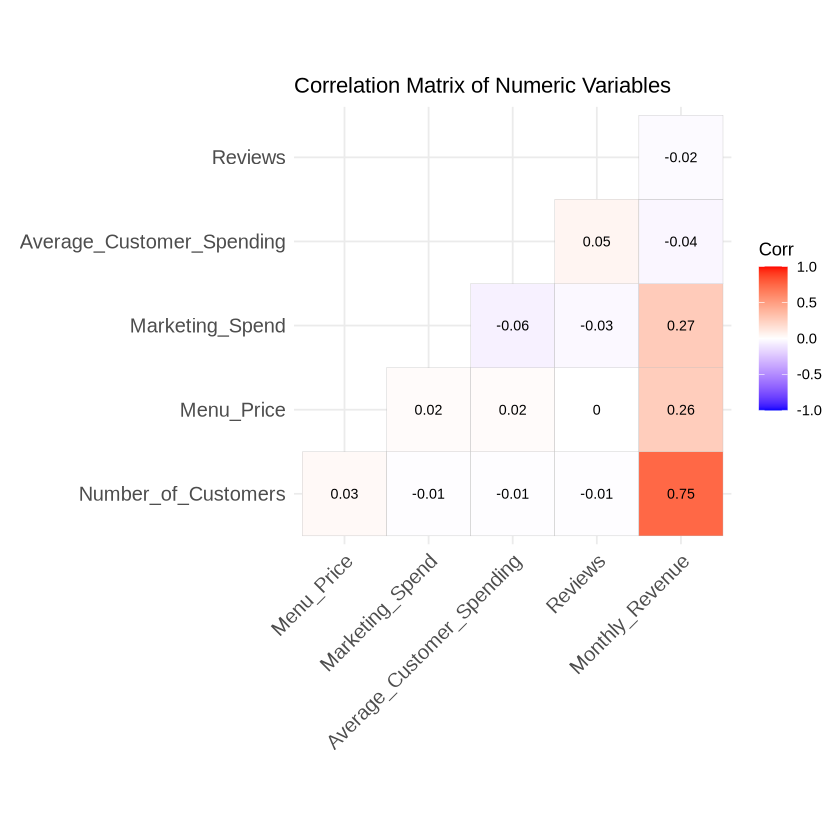

In [9]:
# This visualization would help us in assessing potential multicollinearity issues

# Select only numeric columns
numeric_data <- data_clean %>%
  select_if(is.numeric)

# Calculate the correlation matrix
corr_matrix <- round(cor(numeric_data), 2)

# Create the correlation heatmap
plot_corr <- ggcorrplot(
  corr_matrix,
  type = "lower",
  lab = TRUE,
  lab_size = 3,
  title = "Correlation Matrix of Numeric Variables"
)

plot_corr

## Interpretation of visualization 2

We can interpret that:

- `Number_of_Customers` has a strong positive correlation with `Monthly_Revenue` (0.75)

- `Marketing_Spend` (0.27) and `Menu_Price` (0.26) show weak positive correlations with `Monthly_Revenue`. **(Might be an issue)**

- `Average_Customer_Spending` (0.05) and `Reviews` (-0.02) have negligible impact on revenue.

**Most variables have weak or no correlation with each other.**

# Methods and Results: Plan

To examine the association between the number of customers visiting a restaurant per month and the explanatory variables, I propose using a **Poisson regression model**. This method is appropriate because the response variable, Number_of_Customers, is a count variable that fits the assumptions of Poisson distribution under typical circumstances.

### Why is this method appropriate?
Poisson regression is commonly used when the response variable is a count. It enables interpreting the association of explanatory variables through rate ratios while accounting for the discrete nature of the response variable. Additionally, it aligns with the structure of the dataset and the question, which focuses on association rather than prediction or causality.

### Assumptions:
- The mean and variance of the response variable are equal (equidispersion).

- Observations are independent.

- The log of the expected count is linearly related to the predictors.

### Potential Limitations:

The primary limitation is overdispersion, where the variance exceeds the mean, potentially leading to underestimated standard errors and inflated Type I error rates.

If overdispersion is present, I will switch to a Quasi-Poisson regression model, which maintains the structure of the Poisson model but corrects the standard errors by introducing a dispersion parameter.



## Computational Code and Output

In [10]:
# Fit an initial Poisson regression model using all potential predictors
# Response variable: Number_of_Customers
# Predictors: All other variables
# Family: poisson with log link function

model_poisson <- glm(
  Number_of_Customers ~ Menu_Price + Marketing_Spend + Average_Customer_Spending +
    Cuisine_Type + Promotions + Reviews + Monthly_Revenue,
  family = poisson(link = "log"),
  data = data_clean
)

summary(model_poisson)


Call:
glm(formula = Number_of_Customers ~ Menu_Price + Marketing_Spend + 
    Average_Customer_Spending + Cuisine_Type + Promotions + Reviews + 
    Monthly_Revenue, family = poisson(link = "log"), data = data_clean)

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                3.200e+00  2.351e-02 136.116  < 2e-16 ***
Menu_Price                -8.359e-03  3.966e-04 -21.077  < 2e-16 ***
Marketing_Spend           -2.169e-02  7.835e-04 -27.677  < 2e-16 ***
Average_Customer_Spending  3.297e-04  3.780e-04   0.872   0.3831    
Cuisine_TypeItalian        1.822e-03  1.249e-02   0.146   0.8840    
Cuisine_TypeJapanese       1.060e-02  1.201e-02   0.883   0.3774    
Cuisine_TypeMexican       -2.148e-02  1.224e-02  -1.754   0.0794 .  
Promotions1                4.365e-02  8.679e-03   5.029 4.93e-07 ***
Reviews                   -9.990e-05  1.495e-04  -0.668   0.5040    
Monthly_Revenue            4.232e-03  4.688e-05  90.271  < 2e-16 ***
---
Sign

In [11]:
# Check for Overdispersion

# Calculate dispersion ratio (Pearson Chi-squared / degrees of freedom)
# Ratio >> 1 suggests overdispersion (variance > mean)

dispersion_ratio <- sum(residuals(model_poisson, type = "pearson")^2) / model_poisson$df.residual
round(dispersion_ratio, 2)

[1] 5.58

### Overdispersion Detected!! 
### Switching to Quasi-Poisson Model

In [12]:
# Fitting a quasi-Poisson Model

# Addressing overdispersion found in the Poisson model by using a quasi-Poisson Model.
# This model estimates a dispersion parameter to adjust standard errors,
# providing more reliable inference when overdispersion is present.

model_quasi <- glm(
    Number_of_Customers ~ Menu_Price + Marketing_Spend + Average_Customer_Spending +
      Cuisine_Type + Promotions + Reviews + Monthly_Revenue,
    family = quasipoisson(link = "log"),
    data = data_clean
  )
summary(model_quasi)


Call:
glm(formula = Number_of_Customers ~ Menu_Price + Marketing_Spend + 
    Average_Customer_Spending + Cuisine_Type + Promotions + Reviews + 
    Monthly_Revenue, family = quasipoisson(link = "log"), data = data_clean)

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                3.2004105  0.0555426  57.621   <2e-16 ***
Menu_Price                -0.0083592  0.0009369  -8.923   <2e-16 ***
Marketing_Spend           -0.0216856  0.0018509 -11.716   <2e-16 ***
Average_Customer_Spending  0.0003297  0.0008929   0.369   0.7121    
Cuisine_TypeItalian        0.0018220  0.0294973   0.062   0.9508    
Cuisine_TypeJapanese       0.0105985  0.0283662   0.374   0.7088    
Cuisine_TypeMexican       -0.0214802  0.0289247  -0.743   0.4579    
Promotions1                0.0436490  0.0205033   2.129   0.0335 *  
Reviews                   -0.0000999  0.0003531  -0.283   0.7773    
Monthly_Revenue            0.0042320  0.0001107  38.214   <2e-16 ***
---

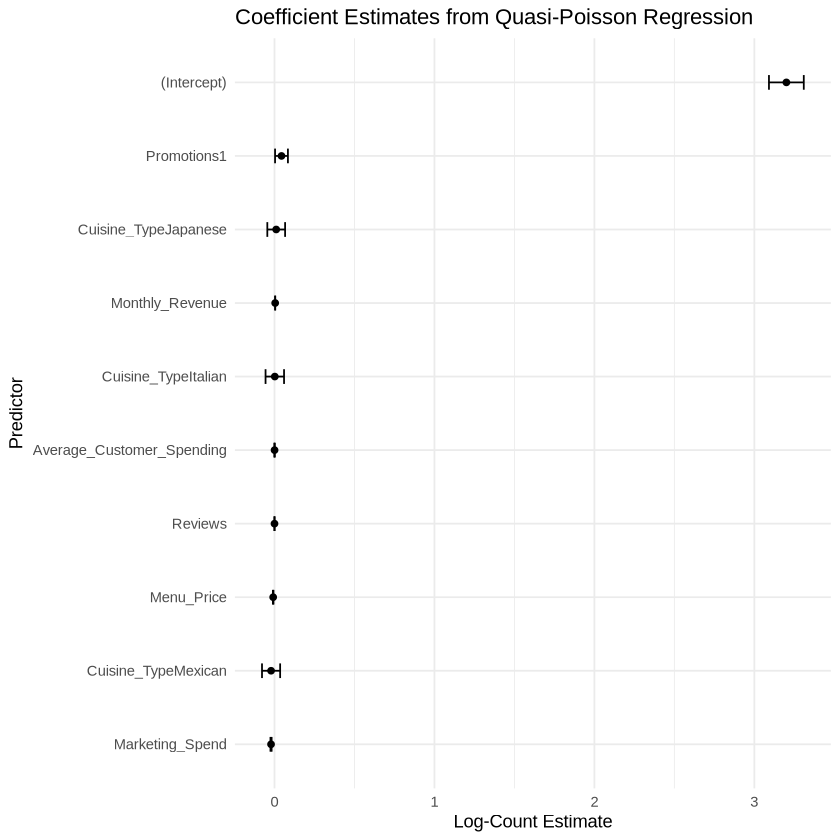

In [13]:
model_tidy <- tidy(model_quasi, conf.int = TRUE)

# Plotting coefficients
ggplot(model_tidy, aes(x = reorder(term, estimate), y = estimate)) +
  geom_point() +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2) +
  coord_flip() +
  labs(
    title = "Coefficient Estimates from Quasi-Poisson Regression",
    x = "Predictor",
    y = "Log-Count Estimate"
  ) +
  theme_minimal()

### Detailed Interpretation of Quasi-Poisson Model Results

Due to significant overdispersion detected in an initial Poisson model (Dispersion parameter = 5.58 >> 1), a **quasi-Poisson model** was employed. This approach accounts for the observed Poisson variation by adjusting standard errors, leading to more reliable statistical inference.

1.  **Statistically Significant Predictors & their interpretations (p < 0.05):**
    *   **`Monthly_Revenue`**: This variable has the strongest positive association with the `Number_of_Customers` (Estimate = 0.0042, p < 0.001). For every \$1 increase in monthly revenue, the expected log-count of customers increases by 0.0042, holding all other variables constant. This translates to a multiplicative increase in the customer count by exp(0.0042) ≈ 1.0042. Given the likely scale of monthly revenue, this effect is substantial.
    *   **`Promotions1`**: Actively running promotions (compared to not running them) is associated with a statistically significant increase in the expected log-count of customers (Estimate = 0.0436, p = 0.0335). This suggests restaurants with promotions tend to have approximately exp(0.0436) = 1.045 times more customers than those without, holding other factors constant.
    *   **`Menu_Price`**: Higher menu prices show a statistically significant **negative** association with the log-count of customers (Estimate = -0.0084, p < 0.001). A \$1 increase in menu price is associated with a decrease in the expected log-count of customers by 0.0084, implying a multiplicative factor of exp(-0.0084) ≈ 0.9916, holding other variables constant.
    *   **`Marketing_Spend`**: Similarly, higher marketing spend shows a statistically significant **negative** association with the log-count of customers (Estimate = -0.0217, p < 0.001). A $1 increase in marketing spend is associated with a decrease in the expected log-count of customers by 0.0217 (multiplicative factor exp(-0.0217) ≈ 0.9785), holding other variables constant.

2.  **Non-Significant Predictors (p >= 0.05):**
    *   `Average_Customer_Spending`, `Reviews`, and `Cuisine_Type` (Italian, Japanese, Mexican) did not show a statistically significant association with the `Number_of_Customers` in this model after accounting for the effects of the other included variables.

3.  **Model Fit and Considerations:**
    *   The `quasi-Poisson model` appropriately addresses the overdispersion present in the data.
      
    *   **Multicollinearity:** The counter-intuitive negative coefficients for `Menu_Price` and `Marketing_Spend` strongly suggest the presence of multicollinearity, as hinted at in the Exploratory Data Analysis
  

**Summary:** The model indicates that higher revenue and running promotions are positively associated with customer counts. However, the apparent negative associations for menu price and marketing spend are likely artifacts of multicollinearity rather than representing their true independent effects.

## Model Assessment

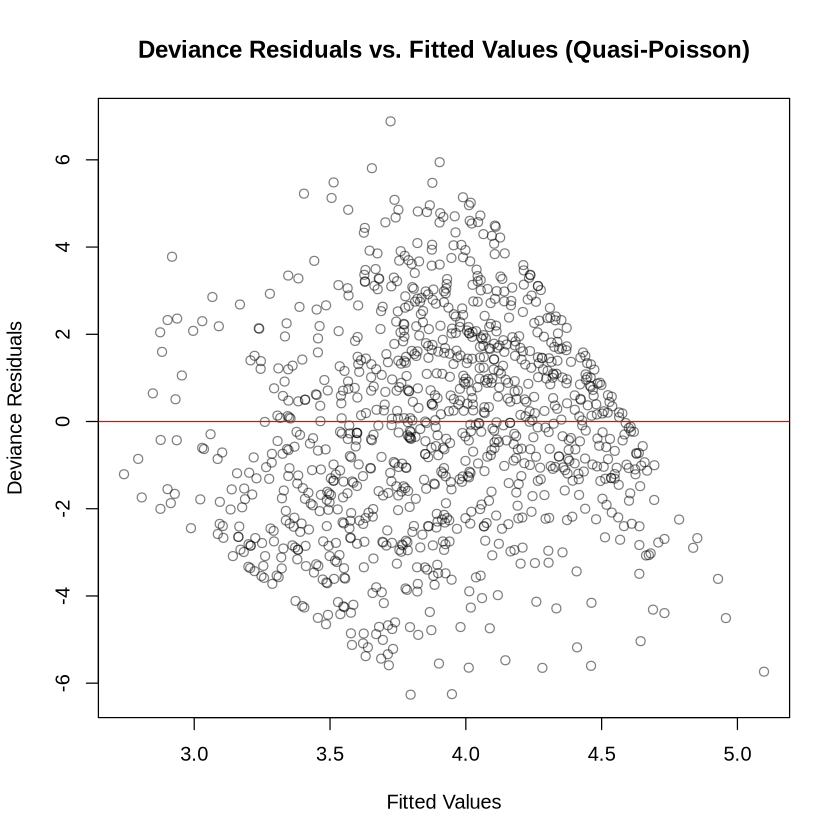

In [14]:
# We carry out residual analysis for the model assessment.

# Extract fitted values
fitted_vals_link <- predict(model_quasi, type = "link")
deviance_resids <- residuals(model_quasi, type = "deviance")

# Create the plot
plot(
  x = fitted_vals_link,
  y = deviance_resids,
  main = "Deviance Residuals vs. Fitted Values (Quasi-Poisson)",
  xlab = "Fitted Values",
  ylab = "Deviance Residuals",
  col = rgb(0, 0, 0, 0.5)
)

# Adding a horizontal reference line at zero
abline(h = 0, col = "red")

### Interpretation: 
- There is a mild pattern that the variance increases with the fitted values, but the quasi-Poisson Model is the appropriate model to deal with that. So we can conclude that the model is the right fit.
  

# Discussion

This analysis aimed to investigate the association between various restaurant characteristics and the number of monthly customers. The primary goal was inference, identifying which factors showed the strongest statistical **association** to footfall. 

Due to observed overdispersion in the count data, a **quasi-Poisson model** was employed.

**Summary of Findings and Implications:**
    
- The results indicated that `Monthly_Revenue` had the strongest statistically significant positive association with the number of customers, suggesting that overall business success is strongly linked to customer traffic in this dataset.

- The use of `Promotions` also showed a significant positive association, implying that promotional activities are linked to higher customer counts, holding other factors constant.

- These findings align with general business intuition, suggesting that higher revenue streams and active marketing promotions correlate with greater customer engagement.

**Unexpected Results:**

- While the positive associations for revenue and promotions were expected, the model yielded statistically significant *negative* coefficients for both `Menu_Price` and `Marketing_Spend`. This is counter-intuitive, as one might expect higher marketing spend to attract more customers, and the effect of menu price could be complex but not necessarily strongly negative.
  
- As highlighted in the Exploratory Data Analysis (EDA) which showed moderate correlations between these predictors and `Monthly_Revenue`, and further supported by the model results, **multicollinearity** is the most likely explanation for these unexpected negative coefficients. The model struggles to disentangle the individual effects of highly correlated predictors.

**Model Limitations and Potential Improvements:**
The primary limitation identified is **multicollinearity** between predictor variables, particularly involving `Monthly_Revenue`, `Marketing_Spend`, and `Menu_Price`.

**This can be addressed by:**
*   Employing variable selection techniques
*   Carefully considering the removal of one or more highly correlated predictors based on domain knowledge or statistical criteria.

**Future Implications:**
* Future studies can look into identifying causal implications on customer footfall if data from controlled experiments become available.
* They could also look into studying the association of more factors other than the ones in this dataset.

# References

1. **Dataset Source:**  
   MrSimple07. (2024). *Restaurants Revenue Prediction* [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/7420974

2. **Statistical Methods:**  
   McCullagh, P., & Nelder, J. A. (1989). *Generalized Linear Models* (2nd ed.). Chapman and Hall/CRC. https://doi.org/10.1007/978-1-4899-3242-6

3. **Quasi-Poisson Regression:**  
   Ver Hoef, J. M., & Boveng, P. L. (2007). Quasi-Poisson vs. negative binomial regression: how should we model overdispersed count data? *Ecology*, 88(11), 2766-2772. https://doi.org/10.1890/07-0043.1

4. **Business Analytics Applications:**  
   Davenport, T. H., & Harris, J. G. (2007). *Competing on Analytics: The New Science of Winning*. Harvard Business Press.

5. **R Statistical Computing:**  
   R Core Team (2024). *R: A Language and Environment for Statistical Computing*. R Foundation for Statistical Computing, Vienna, Austria. https://www.R-project.org/